In [24]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from PIL import Image
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [25]:
tf.__version__

'1.5.0'

In [26]:
from utils import label_map_util
from utils import visualization_utils as vis_util

In [27]:
# What model to download.
#MODEL_NAME = 'faster_rcnn_resnet101_coco_2018_01_28'
#MODEL_FILE = MODEL_NAME + '.tar.gz'
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = r'D:\Thesis\Models\faster_rcnn_resnet101_coco_2018_01_28\frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

In [28]:
np.random.seed(1)

In [29]:
#opener = urllib.request.URLopener()
#opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
#tar_file = tarfile.open(MODEL_FILE)
#for file in tar_file.getmembers():
#  file_name = os.path.basename(file.name)
#  if 'frozen_inference_graph.pb' in file_name:
#    tar_file.extract(file, os.getcwd())

In [30]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [31]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [32]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [33]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [34]:
dataDir='D:\Thesis\Coco'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [35]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


In [36]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
vehicle food electronic indoor person sports animal appliance kitchen outdoor furniture accessory


In [37]:
# initialize COCO api for caption annotations
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [38]:
# get all images containing given categories, select one at random
#catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
catIds = coco.getCatIds(catNms=['person']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds()
#imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

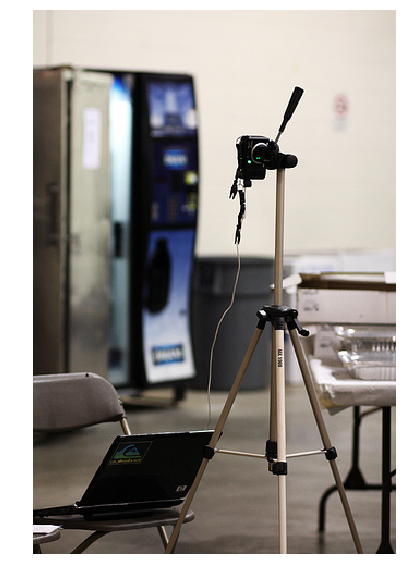

In [39]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
image = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(image)
plt.show()

In [40]:
image.shape

(500, 333, 3)

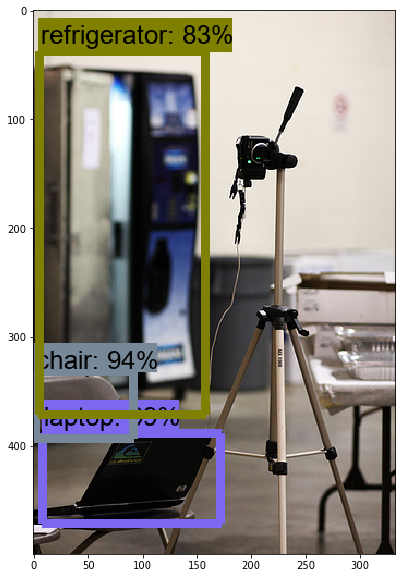

In [41]:
# image = Image.open(image_path)
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
# image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
# image_np_expanded = np.expand_dims(image, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image, detection_graph)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
  image,
  output_dict['detection_boxes'],
  output_dict['detection_classes'],
  output_dict['detection_scores'],
  category_index,
  instance_masks=output_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  line_thickness=8)
#plt.figure(figsize=IMAGE_SIZE)
#plt.imshow(image_np)
plt.figure()
plt.imshow(image)

A camera sits on a tripod connected to a laptop.
A camera with a computer is set up on a tripod
A camera and tripod is shown with a laptop.
a tripod sitting next to  a laptop
Camera equipment is set up in a room with vending machines in the background.


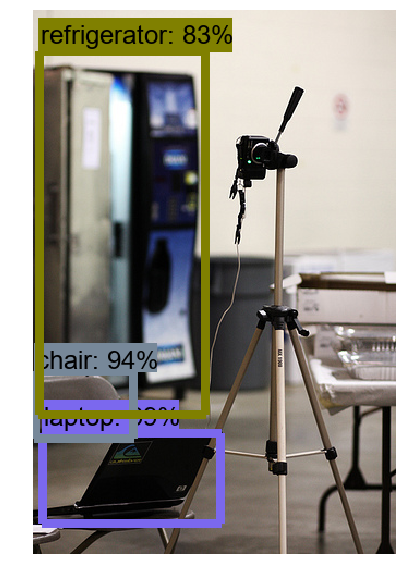

In [42]:
# load and display caption annotations
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.imshow(image); plt.axis('off'); plt.show()

In [43]:
image

array([[[217, 209, 198],
        [218, 210, 199],
        [220, 210, 200],
        ..., 
        [218, 208, 198],
        [217, 207, 197],
        [218, 205, 196]],

       [[219, 211, 200],
        [219, 211, 200],
        [219, 211, 200],
        ..., 
        [218, 208, 198],
        [218, 208, 198],
        [217, 207, 197]],

       [[218, 210, 199],
        [218, 210, 199],
        [218, 210, 199],
        ..., 
        [219, 209, 199],
        [219, 209, 199],
        [218, 208, 198]],

       ..., 
       [[ 16,  16,   8],
        [ 12,  11,   7],
        [ 14,  15,   9],
        ..., 
        [ 45,  44,  40],
        [100,  85,  82],
        [102,  92,  83]],

       [[ 17,  14,   7],
        [ 13,   9,   6],
        [ 14,  15,   9],
        ..., 
        [ 19,  20,  15],
        [ 84,  69,  66],
        [100,  89,  83]],

       [[ 15,  12,   5],
        [ 14,   9,   5],
        [ 14,  14,   6],
        ..., 
        [  7,   9,   4],
        [ 61,  47,  46],
        [ 98,  85,

In [44]:
img

{'coco_url': 'http://images.cocodataset.org/val2017/000000011813.jpg',
 'date_captured': '2013-11-24 04:49:37',
 'file_name': '000000011813.jpg',
 'flickr_url': 'http://farm4.staticflickr.com/3545/3411897599_c3ae826bbb_z.jpg',
 'height': 500,
 'id': 11813,
 'license': 2,
 'width': 333}